# Tutorial - Create an object detection Ship Detector solution

Object detection is a form of computer vision in which a machine learning model is trained to classify individual instances of objects in an image, and indicate a bounding box that marks its location. You can think of this as a progression from image classification (in which the model answers the question "what is this an image of?") to building solutions where we can ask the model "what objects are in this image, and where are they?".

For example, a shipping company could use object detection on satellite images over time to predict the time one of their cargo ships will be in port by detecting and counting the ships waiting and being processed.

The Custom Vision cognitive service in Microsoft Azure provides a cloud-based solution for creating and publishing custom object detection models. In Azure, you can use the Custom Vision service to train an image classification model based on existing images. There are two elements to creating an image classification solution. First, you must train a model to recognize different classes using existing images. Then, when the model is trained you must publish it as a service that can be consumed by applications.

To test the capabilities of the Custom Vision service to detect objects in images, we'll use a simple Python code to call the deployed trained model. The same principles and functionality apply in real-world solutions, such as earth observation and analysis.

# Test the Model

In [1]:
# # Run if necessary. This may need to be run when first setting up the environment. Other packages below may also need to be installed with pip depending on the environment.
# !pip install azure-cognitiveservices-vision-customvision


In [4]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
import csv
from msrest.authentication import ApiKeyCredentials
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import os


Model Name: Ship-Detector
Predicted Object Threshold: 15.0%
Detecting ships in Test Images/Ship_Test.png
Ship 1, Prediction Probability = 76.9%
Ship 2, Prediction Probability = 72.1%
Ship 3, Prediction Probability = 58.4%
Ships Detected > 15.0% probability = 3
Results saved in Output/Ship_Test_tagged.jpg


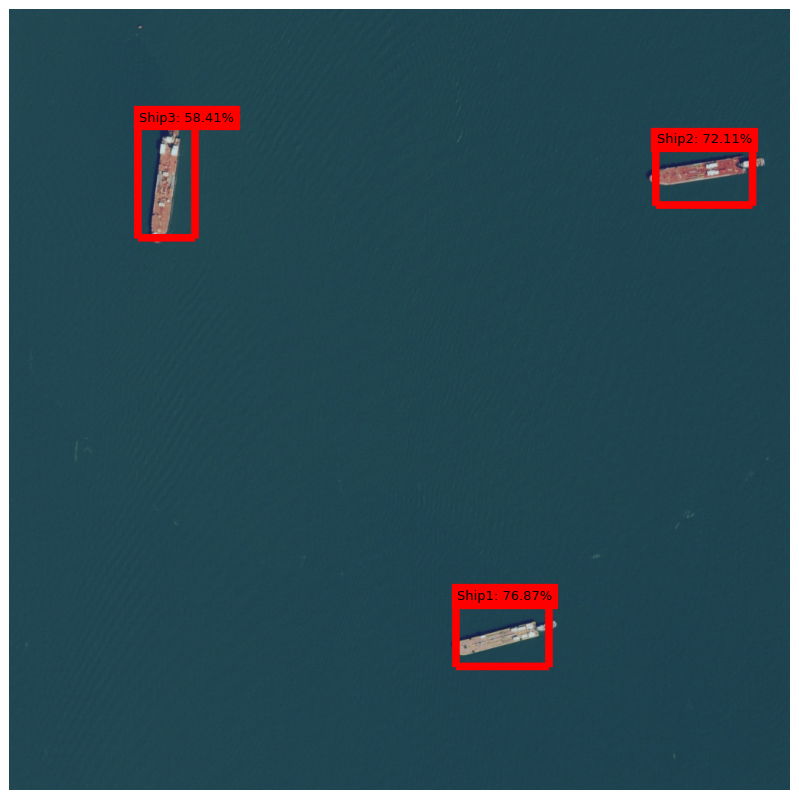

In [7]:
def main():
    from dotenv import load_dotenv

    try:
        # Get Configuration Settings
        load_dotenv()
        prediction_endpoint = os.getenv('PredictionEndpoint')
        prediction_key = os.getenv('PredictionKey')
        project_id = os.getenv('ProjectID')
        model_name = os.getenv('ModelName')
        predicted_object_threshold = float(os.getenv('Predicted_Object_Threshold'))

        # Authenticate a client for the Prediction API
        credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
        prediction_client = CustomVisionPredictionClient(endpoint=prediction_endpoint, credentials=credentials)

        # Create the output text variable
        output_text = ''
        
        # Create test image file path. You can substitute your own images or change the file name to test other images.
        image_file = 'Ship_Test.png'
        test_image_folder_path = 'Test Images/'
        image_file_with_path = test_image_folder_path + image_file
        
        # Create output file paths
        output_folder_path = 'Output/'
        output_file = os.path.splitext(image_file)[0] + '_tagged.jpg'
        output_file_text = os.path.splitext(output_file)[0] + '.txt'
        output_file_csv = os.path.splitext(output_file)[0] + '.csv'
        output_file_with_path = output_folder_path + output_file
        output_file_text_with_path = output_folder_path + output_file_text
        output_file_csv_with_path = output_folder_path + output_file_csv

        #Create csv file with headers
        with open(output_file_csv_with_path, 'w', newline='')as file:
            writer = csv.writer(file)
            writer.writerow(["Object", "Catagory", "Lat", "Long", "Probability", "Image"])

        # Print the Model Iteration Used and Predicted Object Threshold
        print(output_text, file=open(output_file_text_with_path, 'w'))
        print(output_text)
        output_text = 'Model Name: ' + model_name
        output_text = output_text + '\n'
        output_text = output_text + 'Predicted Object Threshold: ' + str(predicted_object_threshold) + '%'
       
        # Load image and get height, width and channels
        output_text = output_text + '\n'
        output_text = output_text + 'Detecting ships in ' + image_file_with_path
        image = Image.open(image_file_with_path)
        
        # plt.imshow(image)
        h, w, ch = np.array(image).shape

        # Detect objects in the test image
        with open(image_file_with_path, mode="rb") as image_data:
            results = prediction_client.detect_image(project_id, model_name, image_data)
        
        # Ship location information
        # Set Latititude and Longitudinal coordinates here for demo purposes. If using a capable image set, pull the information from the images and replace.
        Lat = [33.714157, 33.725864, 33.725838]
        Long = [-118.212067, -118.206078, -118.219734]

        # Create a figure for the results
        fig = plt.figure(figsize=(11,11), frameon=False, dpi=94)
        plt.axis('off')

        # Display the image with boxes around each detected object
        draw = ImageDraw.Draw(image)
        lineWidth = int(w/100)
        color = 'red'
        count = 0
        for prediction in results.predictions:
            # Only show objects with a > predicted_object_threshold probability
            if (prediction.probability*100) > predicted_object_threshold:
                # print('Ship ',count+1,', Prediction Probability = ',round(prediction.probability*100,1), '%', file=open(output_file_text_with_path, 'a'))
                output_text = output_text + '\n'
                output_text = output_text + 'Ship ' + str(count+1) +', Prediction Probability = ' + str(round(prediction.probability*100,1)) + '%'
                # Box coordinates and dimensions are proportional - convert to absolutes
                left = prediction.bounding_box.left * w 
                top = prediction.bounding_box.top * h 
                height = prediction.bounding_box.height * h
                width =  prediction.bounding_box.width * w
                # Draw the box. Pull Lat and Long data if available.
                points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
                draw.line(points, fill=color, width=lineWidth)
                # Add the tag name and probability
                annotate_text = prediction.tag_name + str(count+1)
                plt.annotate(annotate_text + ": {0:.2f}%".format(prediction.probability * 100),(left,top), backgroundcolor=color)
                # Write to csv file
                with open(output_file_csv_with_path, 'a', newline='')as file:
                    writer = csv.writer(file)
                    writer.writerow(['Ship ' + str(count+1), "Ship", Lat[count], Long[count], str(round(prediction.probability*100,1)), image_file])
                count += 1

        plt.imshow(image)
        output_text = output_text + '\n'
        output_text = output_text + 'Ships Detected > ' + str(predicted_object_threshold) + '% probability = ' + str(count)
        fig.savefig(output_file_with_path, dpi='figure')
        output_text = output_text + '\n'
        output_text = output_text + 'Results saved in ' + output_file_with_path
        print(output_text, file=open(output_file_text_with_path, 'a'))
        print(output_text)

    except Exception as ex:
        output_text = output_text + '\n'
        output_text = output_text + ex
        print(output_text, file=open(output_file_text_with_path, 'a'))
        print(output_text)


if __name__ == "__main__":
    main()